# Make Prediction Dataframe
This notebook aim to make dataframe that contain:
- datetime
- prediction

This dataframe later will be displayed in the website to show that the model work well

**input**:
- outputs/train_x_second_v3.npy -> numpy array, encoded, scaled, reshaped dataset to 3d before train-test-split (features)
- outputs/train_y_second_v3.npy -> numpy array, encoded, scaled, reshaped dataset before train-test-split (label)
- outputs/MM_scaler_second_v2.joblib -> minmax scaler object
- model/Tuned/BiLSTM_second_v3.h5 -> final model
- dataset/secondhalf_v4.csv -> dataset final, stil in dataframe form, haven't been encoded, scaled, reshaped

**output**:
- df_train -> sliced secondhalf_v4 from the first record to last record that contained in X_train
- df_test -> sliced secondhalf_v4 from 1 hour after last record that contained in X_train to last record
- df_predict

# Import Libs and Load Things

In [1]:
import pandas as pd
import numpy as np
import joblib
from matplotlib import pyplot as plt

In [2]:
from tensorflow.keras.models import load_model
model = load_model('model/Tuned/BiLSTM_second_v3.h5')

In [3]:
df = pd.read_csv('dataset/secondhalf_v4.csv')

In [4]:
scaler = joblib.load('outputs\MM_scaler_second_v2.joblib')

In [5]:
X = np.load('outputs/train_x_second_v3.npy')
y = np.load('outputs/train_y_second_v3.npy')

In [6]:
print(f'X shape: {X.shape}')
print(f'y shape: {y.shape}')

X shape: (16924, 24, 62)
y shape: (16924, 1)


# Train Test Split

In [7]:
total_sample = X.shape[0]
split_index = int(total_sample * 0.9)

X_train = X[:split_index]
y_train = y[:split_index]
X_test = X[split_index:]
y_test = y[split_index:]

In [8]:
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (15231, 24, 62)
X_test shape: (1693, 24, 62)


In [9]:
n_future = 1   # Number of data we want to look into the future based on the past data.
n_past = 24  # Number of past data we want to use to predict the future.

In [10]:
df_train = df[:split_index+n_past-1] # from the first record to last record that contained in X_train
df_test = df[split_index+n_past-1:] # from 1 hour after last record that contained in X_train to last record

In [11]:
df_train.tail(1)

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume,date_time
15253,Not a Holiday,124.0,47.0,6.0,120.0,8.0,8.0,268.23,0.0,0.0,40.0,Snow,light snow,5194.0,2017-03-08 09:00:00


In [12]:
df_test.head(1)

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume,date_time
15254,Not a Holiday,144.0,44.0,5.0,130.0,8.0,8.0,268.35,0.0,0.0,75.0,Snow,light snow,4454.0,2017-03-08 10:00:00


In [13]:
# make prediction of X_train then unscale it so it show the real value
pred_train = model.predict(X_train)
pred_train_copies = np.repeat(pred_train, X.shape[2], axis=-1)
pred_train_unscaled = scaler.inverse_transform(pred_train_copies)[:,-1]

476/476 [==============================] - 5s 6ms/step


In [14]:
# get the value of traffic_volume from df_train for plotting purpose
true_value = df[24:split_index+n_past]['traffic_volume'].values

In [15]:
len(pred_train_unscaled)

15231

In [16]:
len(true_value)

15231

In [17]:
from sklearn.metrics import mean_absolute_error

mae = mean_absolute_error(pred_train_unscaled, true_value)
print(mae)

157.75744059363132


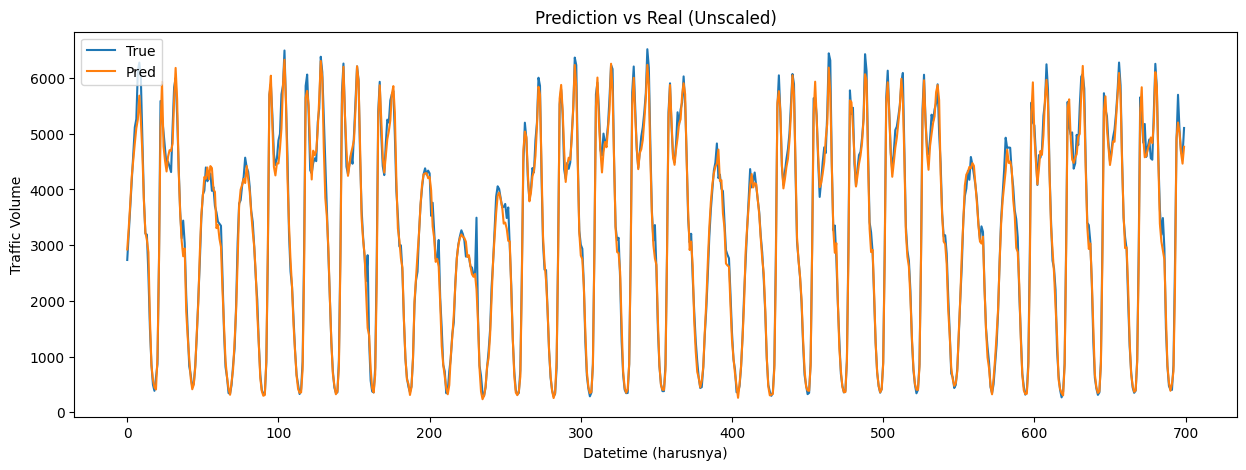

In [18]:
# Plot Prediction vs Real Data. Just check how well the predict on X_train
plt.figure(figsize=(15,5))
plt.plot(true_value[300:1000])
plt.plot(pred_train_unscaled[300:1000])
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['True','Pred'], loc='upper left')
plt.show()

In [19]:
import math

`last 4 feature: day, month, time, traffic_volume`

In [20]:
# take the first instance of X_train (unscaled)
first = scaler.inverse_transform(X_train[0])
# take the last datetime of the last instance of X_train
datetime_firstlast = [math.trunc(round(x)) for x in first[-1][-4:-1]]
print(f'last datetime in X_train first instance: month={datetime_firstlast[1]} day={datetime_firstlast[0]} time={datetime_firstlast[2]}')

last datetime in X_train first instance: month=6 day=12 time=19


In [21]:
# take the last instance of X_train (unscaled)
last = scaler.inverse_transform(X_train[-1])
# take the last datetime of the last instance of X_train
datetime_lastlast = [math.trunc(round(x)) for x in last[-1][-4:-1]]
print(f'last datetime in X_train last instance: month={datetime_lastlast[1]} day={datetime_lastlast[0]} time={datetime_lastlast[2]}')

last datetime in X_train last instance: month=3 day=8 time=9


```
last datetime for each instance in X_train
2015-06-12 19:00 -> first instance
2017-03-08 9:00 -> last instance

datetime of prediction for each instance in X_train
2015-06-12 20:00 -> first instance
2017-03-08 10:00 -> last instance
```

In [22]:
first_pred_datetime = pd.to_datetime('2015-06-12 20:00')
last_pred_datetime = pd.to_datetime('2017-03-08 10:00')

In [23]:
print(first_pred_datetime)
print(last_pred_datetime)

2015-06-12 20:00:00
2017-03-08 10:00:00


In [24]:
predict_range = pd.date_range(first_pred_datetime, last_pred_datetime, freq='H')

In [25]:
print(f'lenght of predict_range: {len(predict_range)}')
print(f'lenght of pred_train: {len(pred_train)}')


lenght of predict_range: 15231
lenght of pred_train: 15231


In [26]:
df_predicted = pd.DataFrame(pred_train_unscaled, index=predict_range)

In [27]:
df_predicted.info()
df_predicted.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15231 entries, 2015-06-12 20:00:00 to 2017-03-08 10:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       15231 non-null  float32
dtypes: float32(1)
memory usage: 178.5 KB


,0
2015-06-12 20:00:00,3418.898193
2015-06-12 21:00:00,2971.505371
2015-06-12 22:00:00,3377.253906
2015-06-12 23:00:00,3200.498535
2015-06-13 00:00:00,2972.044189


In [28]:
df_predicted = df_predicted.rename(columns={0: 'prediction'})

In [29]:
df_predicted.info()
df_predicted.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15231 entries, 2015-06-12 20:00:00 to 2017-03-08 10:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prediction  15231 non-null  float32
dtypes: float32(1)
memory usage: 178.5 KB


,prediction
2015-06-12 20:00:00,3418.898193
2015-06-12 21:00:00,2971.505371
2015-06-12 22:00:00,3377.253906
2015-06-12 23:00:00,3200.498535
2015-06-13 00:00:00,2972.044189


In [30]:
df_predicted.iloc[10:15]

,prediction
2015-06-13 06:00:00,3237.371094
2015-06-13 07:00:00,3252.710693
2015-06-13 08:00:00,3262.851074
2015-06-13 09:00:00,3245.354736
2015-06-13 10:00:00,3230.744141


In [31]:
df.iloc[34:39]

,is_holiday,air_pollution_index,humidity,wind_speed,wind_direction,visibility_in_miles,dew_point,temperature,rain_p_h,snow_p_h,clouds_all,weather_type,weather_description,traffic_volume,date_time
34,Not a Holiday,47.38,64.88,2.38,320.75,4.25,4.25,293.10,0.0,0.0,33.50,Clouds,broken clouds,3201.88,2015-06-13 06:00:00
35,Not a Holiday,49.42,65.08,2.42,320.83,4.17,4.17,293.22,0.0,0.0,36.33,Clouds,broken clouds,3191.08,2015-06-13 07:00:00
36,Not a Holiday,51.46,65.29,2.46,320.92,4.08,4.08,293.33,0.0,0.0,39.17,Clouds,broken clouds,3180.29,2015-06-13 08:00:00
37,Not a Holiday,53.50,65.50,2.50,321.00,4.00,4.00,293.45,0.0,0.0,42.00,Clouds,broken clouds,3169.50,2015-06-13 09:00:00
38,Not a Holiday,55.54,65.71,2.54,321.08,3.92,3.92,293.57,0.0,0.0,44.83,Clouds,broken clouds,3158.71,2015-06-13 10:00:00


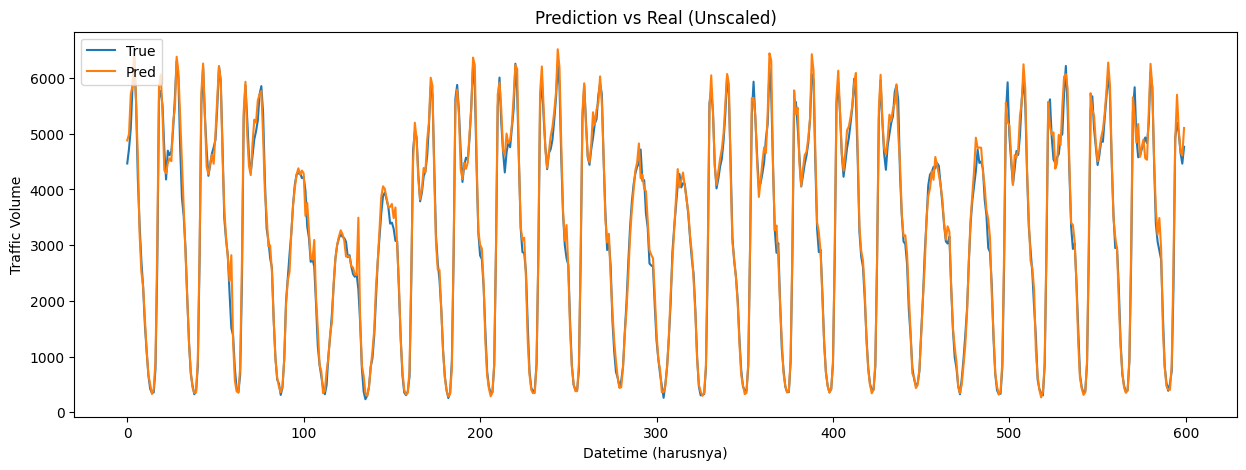

In [32]:
# Plot Prediction vs Real Data. Just check how well the predict on X_train
plt.figure(figsize=(15,5))
plt.plot(df_predicted['prediction'].iloc[400:1000].values)
plt.plot(df['traffic_volume'].iloc[424:1024].values)
plt.title('Prediction vs Real (Unscaled)')
plt.xlabel('Datetime (harusnya)')
plt.ylabel('Traffic Volume')
plt.legend(['True','Pred'], loc='upper left')
plt.show()

In [33]:
# df_train.to_csv('outputs/df_train.csv', index=False)
# df_test.to_csv('outputs/df_test.csv', index=False)

In [34]:
df_predicted['date_time']=df_predicted.index

In [35]:
df_predicted.info()
df_predicted.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15231 entries, 2015-06-12 20:00:00 to 2017-03-08 10:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   prediction  15231 non-null  float32       
 1   date_time   15231 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float32(1)
memory usage: 297.5 KB


,prediction,date_time
2015-06-12 20:00:00,3418.898193,2015-06-12 20:00:00
2015-06-12 21:00:00,2971.505371,2015-06-12 21:00:00
2015-06-12 22:00:00,3377.253906,2015-06-12 22:00:00
2015-06-12 23:00:00,3200.498535,2015-06-12 23:00:00
2015-06-13 00:00:00,2972.044189,2015-06-13 00:00:00


In [36]:
# Move prediction column to the last
df_predicted['prediction'] = df_predicted.pop('prediction')

In [37]:
df_predicted.info()
df_predicted.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 15231 entries, 2015-06-12 20:00:00 to 2017-03-08 10:00:00
Freq: H
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date_time   15231 non-null  datetime64[ns]
 1   prediction  15231 non-null  float32       
dtypes: datetime64[ns](1), float32(1)
memory usage: 297.5 KB


,date_time,prediction
2015-06-12 20:00:00,2015-06-12 20:00:00,3418.898193
2015-06-12 21:00:00,2015-06-12 21:00:00,2971.505371
2015-06-12 22:00:00,2015-06-12 22:00:00,3377.253906
2015-06-12 23:00:00,2015-06-12 23:00:00,3200.498535
2015-06-13 00:00:00,2015-06-13 00:00:00,2972.044189


In [38]:
# df_predicted.to_csv('outputs/df_prediction.csv', index=False)